# Spectral Clustering and Image Segmentation

We talked in class about spectral clustering and how it works. In this notebook you will implement it and then apply it to images as described in [Shi & Malik](https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf).

In [1]:
from typing import Tuple, Dict, Hashable

import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

colors = np.array(['tab:blue', 'orange'])

## Sweep Cuts

The first component you will need is a function computing the best sweep cut. The returned cut $S$ is computed as the $S_t = \{i : v[i] \leq t\}$. Take care to compute the conductance 
$$\phi(S) = \frac{w(E(S, \bar{S})}{\min\left\{\text{vol}(S), \text{vol}(\bar{S})\right\}}$$
of all threshold cuts in $O(|V| + |E|)$ using running sums.

To begin with, you will use your function on the path graph, before applying them to images.

In [3]:
def compute_cut_score(G: nx.graph, S: nx.Graph):
    """
    Helper function for sweep_cut.
    Returns the cut score for the subgraph S of the Graph G.

    \phi(S) = w(E(S, \bar{S})) / min(vol(S), vol(\bar{S}))
    """
    
    #Taking min of vol(S),vol(\bar{S})
    Vol_G = nx.volume(G, G.nodes())
    Vol_S = nx.volume(S, S.nodes())
    
    if Vol_G == Vol_S:
        #No cut happened, return np.inf to not mess with min
        return np.inf
    
    if Vol_S >= Vol_G/2:
        vol = Vol_G - Vol_S
    else:
        vol = Vol_S
        
    #Getting the weights of edges on the boundary of S and summing them
    bound_edges = nx.edge_boundary(G, S.nodes())
    bound_weights = sum(list([G[edge[0]][edge[1]]["weight"] for edge in bound_edges]))
    
    if bound_weights == 0:
        #Cutting nothing...
        return np.inf
    
    res = bound_weights / vol
    return res
    

On the path with 100 nodes the best conductance threshold is thr = 48.000000 and yields conductance 0.010204.


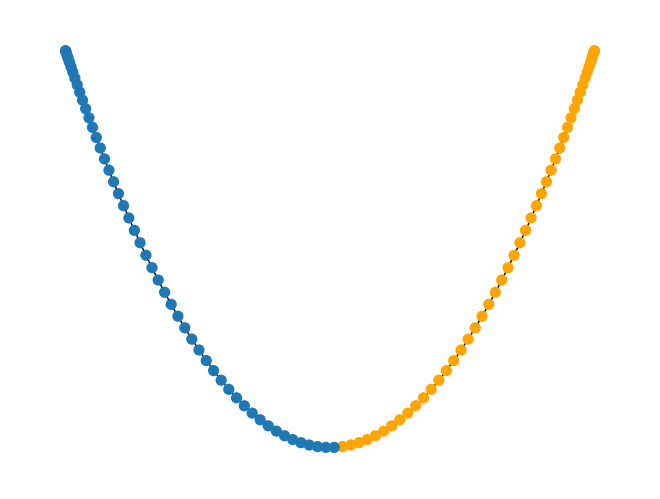

In [4]:
def sweep_cut(G: nx.Graph, x: np.ndarray) -> (float, float, np.ndarray):
    """Sweep Cut
    
    Also known as threshold cut, takes in a graph and a
    1D embedding of the nodes and returns a threshold,
    the conductance from the associated threshold cut and
    a 0/1 vector indicating which side of the cut each node
    belongs to in the best conductance cut.
    
    Parameters
    ----------
    G : nx.Graph
        The graph to compute the threshold cut for.
    x : np.ndarray
        1D Embedding of the nodes in G.
        
    Returns
    -------
    thr : float
        The best conductance threshold.
    conductance : float
        Conductance \phi(S) = w(E(S, \bar{S})) / min(vol(S), vol(\bar{S}))
        of the best threshold cut
    cut : np.ndarray
        0/1 indicator vector of the best threshold cut.
        It holds that cut = (x <= thr)
    """
    n = len(G)
        
    if len(x.shape) != 1:
        raise ValueError(f'Embedding should be one dimensional. Instead got `x` with shape {x.shape}.')
        
    
    #Array of cut scores
    cut_arr = np.zeros(len(x) - 1)
    cut_arr[:] = np.nan
    
    
    #Sort v_2, want the argument list. Don't care about stability, just speed
    x_arg = np.argsort(x, kind='heapsort')

    #Introduce subgraph S
    S = nx.Graph()
    
    #Incrementally add to S, using the nodes of the indices in x_arg
    for i in range(len(x_arg) - 1):
        S.add_node(x_arg[i])
        S.add_edges_from(G.edges(x_arg[i]))

        #Compute cut score for S
        cut_arr[i] = compute_cut_score(G, S)
        
    #The threshold is the minimum cut score
    thr = np.argmin(cut_arr)
    
    #The cut separates the two 
    cut = np.array([1 if i <= thr else 0 for i in range(len(x))])
    
    conductance = cut_arr[thr]
        
    return thr, conductance, cut


n = 100
P = nx.path_graph(n)
nx.set_edge_attributes(P, 1, 'weight')
x = np.linspace(0, 1, n)
thr, cond, cut = sweep_cut(P, x)

print(f'On the path with {n} nodes the best conductance threshold is thr = {thr:.6f} and yields conductance {cond:.6f}.')
pos = nx.spectral_layout(P)
nx.draw(P, pos=pos, node_color=colors[cut], node_size=50)
    

## Spectral clustering

Now that you have the sweep cut implemented, you can implement spectral clustering by simply finding the $k$-th eigenvalue and determining the best cut.

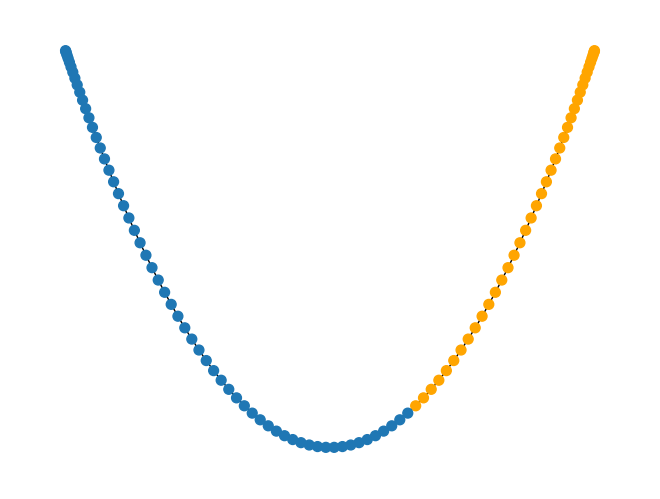

In [9]:
import scipy.sparse
from scipy.sparse.linalg import eigsh


def spectral_clustering(G: nx.Graph, k: int=2) -> (np.ndarray, np.ndarray):
    """Spectral Clustering
    
    Taking a graph `G` and an integer `k`,
    Compute the k-th eigenvector.
    Decide on the best threshold cut.
    Return a vector of its nodes with values
    in {0, 1} indicating which side of the cut each node belongs to.
    
    Parameters
    ----------
    G : nx.Graph
        Graph to do spectral clustering on.
    k : int
        Which eigenvectors to use for clustering.
        
    Returns
    -------
    v : np.ndarray
        The first k+1 eigenvectors.
    cut : np.ndarray
        0/1 indicator vectors of the best threshold cut on the {1, ..., k+1} eigenvectors. 
    """
    n = len(G)
    if not (1 <= k <= n):
        raise ValueError(f'The choice of `k` must be between 1 and n. Instead {k} was passed.')
    
    v = np.zeros((n, k+1))
    cut = [np.zeros(n, int) for _ in range(k)]
    
    #Getting Laplcaian Matrix
    Lap = nx.laplacian_matrix(G)
    
    #Getting eigenvectors
    _ , evect = eigsh(Lap.astype(float), k=k+1, which='SM')
    
    for i, eigenvector in enumerate(evect.T):
        _, _, e_cut = sweep_cut(G, eigenvector)
        v[:, i] = eigenvector 
        cut.append(e_cut)
    return v, cut

_, cut = spectral_clustering(P, 2)
nx.draw(P, pos=pos, node_color=colors[cut[2]], node_size=50)

### Spectral Clustering on Manifolds

First we will work on artificial datasets sampled from manifolds. The machine learning library `sklearn` has some generators for commonly used manifolds that are difficult to learn.

A common way to recover a graph from a manifold is through $k$-nearest neighbors. Each node connects to their $k$ closest neighbors. There are variations on this technique, such as weighing the edges based on their rank or distance. You need to implement a basic undirected version, where the weight is 1 if $v$ is in the $k$NN of $u$ and 2 if $u$ is also in the $k$NN of $v$.

In [ ]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph


def generate_datasets(k=5, noise_multiplier=1):
    # ============
    # Generate datasets. We choose the size big enough to see the scalability
    # of the algorithms, but not too big to avoid too long running times
    # ============

    n_samples = 500
    seed = 17
    noisy_circles = datasets.make_circles(
        n_samples=n_samples, factor=0.5, noise=0.07 * noise_multiplier, random_state=seed
    )
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.10 * noise_multiplier, random_state=seed)
    data = []

    for i, (X, y) in enumerate([noisy_circles, noisy_moons]):
        G = nx.empty_graph(n_samples)
        # TODO: Use `kneighbors_graph` with n_neighbors equal to 5 to construct a graph
        #       a graph from each dataset.
        #       One way to make it into an undirected graph is to take A_u = (A_d + A_d^T) / 2
        #       This will give you the adjacency matrix.
        #       You can make it into a graph using `nx.from_scipy_sparse_matrix

        data.append([X, y, G])

    return data

data = generate_datasets()
fig, ax = plt.subplots(2, 2)

for i, (X, y, G) in enumerate(data):
    ax[0][i].scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
    plt.sca(ax[1][i])
    nx.draw(G, pos=X, node_color=colors[y], node_size=5)
    
    for j in range(2):
        ax[j][i].set_aspect('equal', 'box')
        ax[j][i].set_xticks([])
        ax[j][i].set_yticks([])
        for side in ['right', 'top', 'left', 'bottom']:
            ax[j][i].spines[side].set_visible(False)

Find the best conductance sweep cut from $\mathbf{v}_2$ and plot the result similarly as above.

In [ ]:
fig, ax = plt.subplots(1, 2)


def accuracy_recall_f1(y: np.ndarray, cut: np.ndarray) -> Tuple[float, float, float]:
    cov = cut @ y
    cov2 = (1 - cut) @ (1 - y)
    accuracy = 2 * (max(cov, len(G) / 2 - cov)) / len(G)
    recall = 2 * (max(cov2, len(G) / 2 - cov2)) / len(G)
    f1 = (2 * recall * accuracy) / (recall + accuracy)
    return accuracy, recall, f1


for i, (X, y, G) in enumerate(data):
    # TODO: Use your spectral_clustering function to try and recover the original clusters. 
    n = len(G)
    v = np.zeros((n, 2))
    cut = [np.zeros(n, int)]
    
    
    
    accuracy, recall, f1 = accuracy_recall_f1(y, cut[0])
    print(f'Accuracy is {accuracy:.3f}. Recall = {recall:.3f}. F1-score = {f1:.3f}.')
    plt.sca(ax[i])
    nx.draw(G, pos=X, node_color=colors[cut], node_size=5)
    ax[i].set_aspect('equal', 'box')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    for side in ['right', 'top', 'left', 'bottom']:
        ax[i].spines[side].set_visible(False)

# Choice of $k$

Different choices of $k$ lead to different behaviors. Vary the value for `k` the number of neighbors and observe how the `F1-score` changes.
Comment on what drives this behavior.

In [ ]:
possible_neighbors = [2, 3, 4, 5, 6, 7, 8, 10, 15, 20, 30, 40,  50]
f1 = np.zeros([len(possible_neighbors), 2])
for j, k in enumerate(possible_neighbors):
    # TODO: Generate new datasets with different number of nearest neighbors
    #       and compute the best conductance cut based on the second eigenvector
    ...
        
plt.plot(possible_neighbors, f1[:, 0], label='Circles')
plt.plot(possible_neighbors, f1[:, 1], label='Moons')
plt.axis(ymin=0)
plt.legend()
plt.show()

### Spectral Clustering for Image Segmentation

So far you have implemented sweep cut and spectral clustering. Now you will load some images from the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), construct a graph based on the distance and color difference of the pixels and segment the image using spectral clustering.

Loading the images

In [ ]:
import os
import imageio


from scipy import ndimage

def block_mean(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy//fact * (X//fact) + Y//fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res = res[:((sx // fact) * (sy // fact))]
    res.shape = (sx//fact, sy//fact)
    return res

image_filenames = [f for f in os.listdir('images') if f.endswith('jpg')]
image_names = [os.path.splitext(f)[0] for f in image_filenames]
mask_filenames = [f'{f}.png' for f in image_names]

images = [imageio.imread(os.path.join('images', filename)) / 255 for filename in image_filenames]
masks = [imageio.imread(os.path.join('images', filename)) for filename in mask_filenames]

factor = 5
subsampled_images = []
for i, im in enumerate(images):
    sx, sy, _ = im.shape
    subsampled_im = np.zeros((sx // factor, sy // factor, 3))
    for c  in range(3):
        subsampled_im[:, :, c] = block_mean(im[:, :, c], factor)
    subsampled_images.append(subsampled_im)
    
for im, m in zip(subsampled_images, masks):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(im)
    ax[1].imshow(m)
    
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    plt.show()  

Shi and Malik define a graph by iterating over pixels.
The edge weight between two pixels depends on their physical distance and the norm of the difference between the pixel colors.

$$w_{ij} = e^{\frac{-\|F(i) - F(j)\|_2^2}{0.03}} \times \begin{cases} e^{\frac{-\|X(i) - X(j)\|_2^2}{10}} & \text{if} \|X(i) - X(j)\|_2 < 5 \\ 0 & \text{otherwise} \end{cases}$$

In [ ]:
from datetime import datetime


def generate_graph_from_image(image: np.ndarray, dist=5, sigma_i=0.03, sigma_X=10) -> nx.Graph:
    rows, cols, _ = image.shape
    def coord_to_node(i, j):
        return i * cols + j
    start = datetime.now()
    edges = []
    for i in range(rows):
        print(f'\rProcessed {i + 1:3d} rows in {(datetime.now() - start).total_seconds():7.3f}', end='')
        # TODO: Create an undirected weighted graph from the given image
        #       Each graph should take 10-20s to generate.
        ...
        
        
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G


rows, cols, _ = subsampled_images[1].shape
start = datetime.now()
graphs = []
for im in subsampled_images:
    G = generate_graph_from_image(im, dist=5, sigma_i=0.03, sigma_X=10)
    print(f'\rGenerated graph with {len(G)} nodes and {len(G.edges)} edges in {(datetime.now() - start).total_seconds():6.2f} seconds.')
    graphs.append(G)

It is time to see the result of your work on these images.

In [ ]:
start = datetime.now()
k = 5
cuts = []
eigenvectors = []
for j, G in enumerate(graphs):
    print(f'Performing spectral clustering for {image_names[j]}')
    v, cut = spectral_clustering(G, k=k)
    cut = [c.reshape(subsampled_images[j].shape[:2]) for c in cut]
    eigenvectors.append(v)
    cuts.append(cut)
    print(f'Done after {(datetime.now() - start).total_seconds():.2f} seconds...')

# Visualization

We can visualize the eigenvector, the mask from the sweep cut and how the image looks masked with each cut.
What do you notice in each image? What drives cuts in each image?

Your answer:

In [ ]:
for j, cut in enumerate(cuts):
    print(f'Spectral clustering for {image_names[j]}')
    masked_images = []
    fig, ax = plt.subplots(3, k, figsize=(15, 8))
    for i in range(k):
        ax[0][i].imshow(eigenvectors[j][:, i + 1].reshape(subsampled_images[j].shape[:2]), cmap='Greys')
        ax[1][i].imshow(cut[i], cmap='Greys')

        ind_x, ind_y = np.where(cut[i])
        im_hsv = mpl.colors.rgb_to_hsv(subsampled_images[j])
        im_hsv[ind_x, ind_y, 2] /= 3
        masked_images.append(mpl.colors.hsv_to_rgb(im_hsv))
        ax[2][i].imshow(masked_images[i])

    for a in ax.reshape(-1):
        a.set_xticks([])
        a.set_yticks([])
    plt.show()

# Optional extensions

If you want, you can further experiment with these techniques to expand your udnerstanding.

- How does the distance affect the running time and quality of your cuts?
- What are the effects on the image when changing the $\sigma_I$ and $\sigma_X$ quantities of the graph generation?
- You worked on downsized images. How does the same technique perform on the original images? Why?
- This technique gives one cut each time. How would you extend it to $k$ cuts?
- Future papers normalized the eigenvectors before finding cuts. You can read more on [Ng, Jordan, Weiss](https://papers.nips.cc/paper_files/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf). After the work you have done, implementing that paper is not insurmountable.